# Theoretical Bound vs Numerical Bound

In theory, we have the bound 
$$
\begin{equation}
    \left \| \Delta w \right \| \leq \frac{\tau N}{\alpha(1-\alpha^{\frac{1}{N}})}\left \| x \right \|
\end{equation}  
$$
We compare this to practical implementation. We first use the Dahlquist Equation for comparison

In [5]:
from math import pi
import numpy as np

nt = 128
nx = 128

lx = 2*pi
dx = lx/nx

theta = 0.5

# velocity, CFL, and reynolds number
u = 1
re = 500
cfl = 0.8

# viscosity and timestep
nu = lx*u/re
dt = cfl*dx/u

# advective and diffusive Courant numbers

cfl_u = cfl
cfl_v = nu*dt/dx**2

print(f"{nu = }, {dt = }, {cfl_v = }, {cfl_u = }")

# Spatial domain
mesh = np.linspace(start=-lx/2, stop=lx/2, num=nx, endpoint=False)

nu = 0.012566370614359173, dt = 0.039269908169872414, cfl_v = 0.2048, cfl_u = 0.8


In [6]:
from scipy import sparse
from scipy import linalg
from scipy.sparse import linalg as spla

# Finite difference spatial discretisations                                                                                                                                                   
def gradient_stencil(grad, order):                                                                                                                                                            
    '''                                                                                                                                                                                       
    Return the centred stencil for the `grad`-th gradient                                                                                                                                     
    of order of accuracy `order`                                                                                                                                                              
    '''                                                                                                                                                                                       
    return {                                                                                                                                                                                  
        1: {  # first gradient                                                                                                                                                                
            2: np.array([-1/2, 0, 1/2]),                                                                                                                                                      
            4: np.array([1/12, -2/3, 0, 2/3, -1/12]),                                                                                                                                         
            6: np.array([-1/60, 3/20, -3/4, 0, 3/4, -3/20, 1/60])                                                                                                                             
        },                                                                                                                                                                                    
        2: {  # second gradient                                                                                                                                                               
            2: np.array([1, -2, 1]),                                                                                                                                                          
            4: np.array([-1/12, 4/3, -5/2, 4/3, -1/12]),                                                                                                                                      
            6: np.array([1/90, -3/20, 3/2, -49/18, 3/2, -3/20, 1/90])                                                                                                                         
        },                                                                                                                                                                                    
        4: {  # fourth gradient                                                                                                                                                               
            2: np.array([1,  -4, 6, -4, 1]),                                                                                                                                                  
            4: np.array([-1/6, 2, -13/2, 28/3, -13/2, 2, -1/6]),                                                                                                                              
            6: np.array([7/240, -2/5, 169/60, -122/15, 91/8, -122/15, 169/60, -2/5, 7/240])  # noqa: E501                                                                                     
        }                                                                                                                                                                                     
    }[grad][order]                                                                                                                                                                            
                                                                                                                                                                                              
                                                                                                                                                                                              
def sparse_circulant(stencil, n):                                                                                                                                                             
    '''                                                                                                                                                                                       
    Return sparse scipy matrix from finite difference                                                                                                                                         
    stencil on a periodic grid of size n.                                                                                                                                                     
    '''                                                                                                                                                                                       
    if len(stencil) == 1:                                                                                                                                                                     
        return sparse.spdiags([stencil[0]*np.ones(n)], 0)                                                                                                                                     
                                                                                                                                                                                              
    # extend stencil to include periodic overlaps                                                                                                                                             
    ns = len(stencil)                                                                                                                                                                         
    noff = (ns-1)//2                                                                                                                                                                          
    pstencil = np.zeros(ns+2*noff)                                                                                                                                                            
                                                                                                                                                                                              
    pstencil[noff:-noff] = stencil                                                                                                                                                            
    pstencil[:noff] = stencil[noff+1:]                                                                                                                                                        
    pstencil[-noff:] = stencil[:noff]                                                                                                                                                         
                                                                                                                                                                                              
    # constant diagonals of stencil entries                                                                                                                                                   
    pdiags = np.tile(pstencil[:, np.newaxis], n)                                                                                                                                              
                                                                                                                                                                                              
    # offsets for inner domain and periodic overlaps                                                                                                                                          
    offsets = np.zeros_like(pstencil, dtype=int)                                                                                                                                              
                                                                                                                                                                                              
    offsets[:noff] = [-n+1+i for i in range(noff)]                                                                                                                                            
    offsets[noff:-noff] = [-noff+i for i in range(2*noff+1)]                                                                                                                                  
    offsets[-noff:] = [n-noff+i for i in range(noff)]                                                                                                                                         
                                                                                                                                                                                              
    return sparse.spdiags(pdiags, offsets)

In [7]:
# Mass matrix                                                                                                                                                                                 
M = sparse_circulant([1], nx)                                                                                                                                                                 
                                                                                                                                                                                              
# Advection matrix                                                                                                                                                                            
D = sparse_circulant(gradient_stencil(1, order=2), nx)                                                                                                                                        
                                                                                                                                                                                              
# Diffusion matrix                                                                                                                                                                            
L = sparse_circulant(gradient_stencil(2, order=2), nx)

# Spatial terms                                                                                                                                                                               
K = (u/dx)*D - (nu/dx**2)*L

# Generate block matrices for different coefficients                                                                                                                                          
def block_matrix(l1, l2):                                                                                                                                                                     
    mat = l1*M + l2*K                                                                                                                                                                         
    mat.solve = spla.factorized(mat.tocsc())                                                                                                                                                  
    return mat

In [8]:
# Build the full B1 & B2 matrices
b1col = np.zeros(nt)
b1col[0] = 1/dt
b1col[1] = -1/dt

b1row = np.zeros_like(b1col)
b1row[0] = b1col[0]

b2col = np.zeros(nt)
b2col[0] = theta
b2col[1] = 1-theta

b2row = np.zeros_like(b2col)
b2row[0] = b2col[0]

B1 = linalg.toeplitz(b1col, b1row)                                                                                                                                                            
B2 = linalg.toeplitz(b2col, b2row)

# Build the A0 and A1 matrices
A1 = block_matrix(b1col[0], b2col[0])
A0 = block_matrix(b1col[1], b2col[1])

# Now build the full Jacobian A
A = spla.aslinearoperator(sparse.kron(B1, M) + sparse.kron(B2, K))

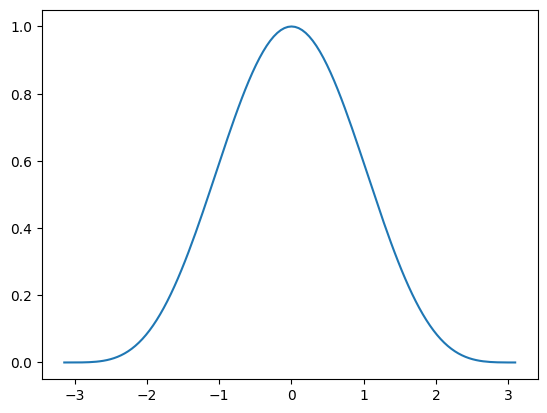

In [9]:
from math import pi

qinit = np.zeros_like(mesh)
qinit[:] = np.cos(mesh/2)**4

# set up timeseries                                                                                                                                                                           
q = np.zeros(nt*nx)                                                                                                                                                                           
rhs = np.zeros_like(q)                                                                                                                                                                        
                                                                                                                                                                                              
q = q.reshape((nt, nx))                                                                                                                                                                       
rhs = rhs.reshape((nt, nx))                                                                                                                                                                   
                                                                                                                                                                                              
# initial guess is constant solution                                                                                                                                                          
q[:] = qinit[np.newaxis, :]                                                                                                                                                                   
rhs[0] -= A0.dot(qinit)                                                                                                                                                                       
                                                                                                                                                                                              
q = q.reshape(nx*nt)
rhs = rhs.reshape(nx*nt)

import matplotlib.pyplot as plt
plt.plot(mesh, qinit)
plt.show()

In [10]:
niterations=0
def gmres_callback(y):
    global niterations
    print(f"niterations: {str(niterations).rjust(3,' ')}  |  residual:  {y}")
    niterations += 1
    return

q, exit_code = spla.gmres(A, rhs,
                          restart=100,
                          callback=gmres_callback,
                          callback_type='pr_norm')

niterations:   0  |  residual:  0.7070849237960032
niterations:   1  |  residual:  0.5773145716875504
niterations:   2  |  residual:  0.4999536192751358
niterations:   3  |  residual:  0.4471582704773686
niterations:   4  |  residual:  0.4081851418673698
niterations:   5  |  residual:  0.377894292505475
niterations:   6  |  residual:  0.3534767719831109
niterations:   7  |  residual:  0.33325074117916814
niterations:   8  |  residual:  0.31613957525678743
niterations:   9  |  residual:  0.30141786511088364
niterations:  10  |  residual:  0.288576627412576
niterations:  11  |  residual:  0.2772467863612419
niterations:  12  |  residual:  0.267153318756189
niterations:  13  |  residual:  0.258086524126604
niterations:  14  |  residual:  0.2498833409557339
niterations:  15  |  residual:  0.24241480502612148
niterations:  16  |  residual:  0.235577397886654
niterations:  17  |  residual:  0.2292869353989769
niterations:  18  |  residual:  0.22347415957927816
niterations:  19  |  residual: 

In [11]:
print(f"gmres exit code: {exit_code}")                                                                                                                 
print(f"gmres iterations: {niterations}")
print(f"residual: {linalg.norm(rhs-A.matvec(q))}")

gmres exit code: 0
gmres iterations: 498
residual: 0.0014149322411493347


In [12]:
from scipy.fft import fft, ifft

class BlockCirculantLinearOperator(spla.LinearOperator):
    def __init__(self, b1col, b2col, block_matrix, nx, alpha=1):
        self.nt = len(b1col)
        self.nx = nx
        self.dim = self.nt*self.nx
        self.shape = tuple((self.dim, self.dim))
        self.dtype = b1col.dtype

        self.gamma = alpha**(np.arange(self.nt)/self.nt)

        eigvals1 = fft(b1col*self.gamma, norm='backward')
        eigvals2 = fft(b2col*self.gamma, norm='backward')
        eigvals = zip(eigvals1, eigvals2)

        self.blocks = tuple((block_matrix(l1, l2)
                             for l1, l2 in eigvals))

    def _to_eigvecs(self, v):
        y = np.matmul(np.diag(self.gamma), v)
        return fft(y, axis=0)

    def _from_eigvecs(self, v):
        y = ifft(v, axis=0)
        return np.matmul(np.diag(1/self.gamma), y)

    def _block_solve(self, v):
        for i in range(self.nt):
            v[i] = self.blocks[i].solve(v[i])
        return v

    def _matvec(self, v):
        y = v.reshape((self.nt, self.nx))                                  
        y = self._to_eigvecs(y)
        y = self._block_solve(y)
        y = self._from_eigvecs(y)
        return y.reshape(self.dim).real

In [17]:
from scipy.fft import fft, ifft
tol = 0.01
class BlockCirculantLinearOperatorInexact(spla.LinearOperator):
    def __init__(self, b1col, b2col, block_matrix, nx, alpha=1):
        self.nt = len(b1col)
        self.nx = nx
        self.dim = self.nt*self.nx
        self.shape = tuple((self.dim, self.dim))
        self.dtype = b1col.dtype

        self.gamma = alpha**(np.arange(self.nt)/self.nt)

        eigvals1 = fft(b1col*self.gamma, norm='backward')
        eigvals2 = fft(b2col*self.gamma, norm='backward')
        eigvals = zip(eigvals1, eigvals2)

        self.blocks = tuple((block_matrix(l1, l2)
                             for l1, l2 in eigvals))

    def _to_eigvecs(self, v):
        y = np.matmul(np.diag(self.gamma), v)
        return fft(y, axis=0)

    def _from_eigvecs(self, v):
        y = ifft(v, axis=0)
        return np.matmul(np.diag(1/self.gamma), y)

    def _block_solve(self, v):
        for i in range(self.nt):
            vi = v[i]
            vi_approx, exit_code = spla.gmres(self.blocks[i], vi, rtol=0.001)
            v[i] = vi_approx
        return v

    def _matvec(self, v):
        y = v.reshape((self.nt, self.nx))                                  
        y = self._to_eigvecs(y)
        y = self._block_solve(y)
        y = self._from_eigvecs(y)
        return y.reshape(self.dim).real

In [31]:
alpha = 0.01
P_exact = BlockCirculantLinearOperator(b1col, b2col, block_matrix, nx, alpha)
P_inexact = BlockCirculantLinearOperatorInexact(b1col, b2col, block_matrix, nx, alpha)


x = q.copy()
outer_iterates_exact = [x]
while True:
    # Perform one outer GMRES iteration (restart=1)
    x, exit_code = spla.gmres(A, rhs, M=P_exact, restart=1)
    # Store the current iterate
    outer_iterates_exact.append(x.copy())
    
    # Compute residual
    residual = np.linalg.norm(rhs - A.matvec(x))
    if residual < 1e-5 * np.linalg.norm(rhs):
        break
    if exit_code == 0:
        break


x = q.copy()
outer_iterates_inexact = [x]
while True:
    # Perform one outer GMRES iteration (restart=1)
    x, exit_code = spla.gmres(A, rhs, M=P_inexact, restart=1)
    # Store the current iterate
    outer_iterates_inexact.append(x.copy())
    
    # Compute residual
    residual = np.linalg.norm(rhs - A.matvec(x))
    if residual < 1e-5 * np.linalg.norm(rhs):
        break
    if exit_code == 0:
        break

niterations=0
q, exit_code = spla.gmres(A, rhs, M=P_exact,
                          callback=gmres_callback,
                          callback_type='pr_norm')

print(f"gmres exit code: {exit_code}")                                                                                                                 
print(f"gmres iterations: {niterations}")
print(f"residual: {linalg.norm(rhs-A.matvec(q))}")

niterations:   0  |  residual:  0.0031723422587866365
niterations:   1  |  residual:  2.6797110537751655e-05
niterations:   2  |  residual:  1.6314829617808078e-07
gmres exit code: 0
gmres iterations: 3
residual: 6.15669929054752e-05


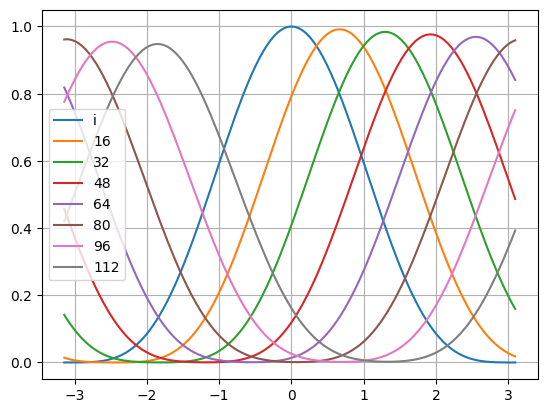

In [32]:
q = q.reshape((nt,nx))
nplot=16
plt.plot(mesh, qinit, label='i')
for i in range(nplot, nt, nplot):
    plt.plot(mesh, q[i], label=str(i))
plt.legend(loc='center left')
plt.grid()
plt.show()

In [33]:
len(outer_iterates_exact)

2

IndexError: list index out of range

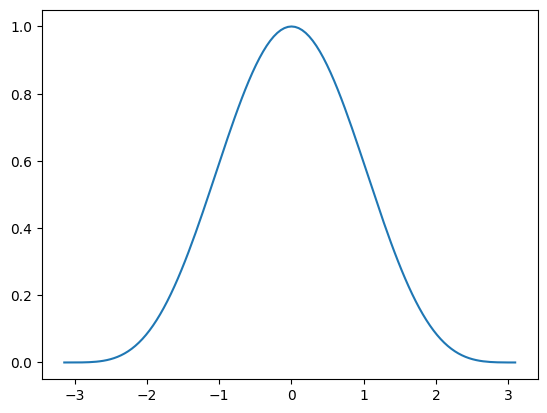

In [ ]:
q = outer_iterates_exact[-1]
q = q.reshape((nt,nx))
nplot=16
plt.plot(mesh, qinit, label='i')
for i in range(nplot, nt, nplot):
    plt.plot(mesh, q[i], label=str(i))
plt.legend(loc='center left')
plt.grid()
plt.show()
